<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/jax-cosmo-paper/blob/master/notebooks/DES_Y1_3x2pt_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Illustration of JAX-cosmo on a DES Y1-like analysis

In [1]:
%pylab inline
import sys
sys.path.append('/Users/kunhao/Dropbox/code/projects/jax_late_mod/jax_cosmo_late_mod')
import os
import jax
import jax.numpy as np
import jax_cosmo as jc
import numpy as onp

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Retrieving  the nz data

In [2]:
# Let's grab the data file
from astropy.io import fits
if not os.path.isfile('2pt_NG_mcal_1110.fits'):
    !wget http://desdr-server.ncsa.illinois.edu/despublic/y1a1_files/chains/2pt_NG_mcal_1110.fits

nz_source=fits.getdata('2pt_NG_mcal_1110.fits', 6)
nz_lens=fits.getdata('2pt_NG_mcal_1110.fits', 7)

Text(0.5, 0, 'z')

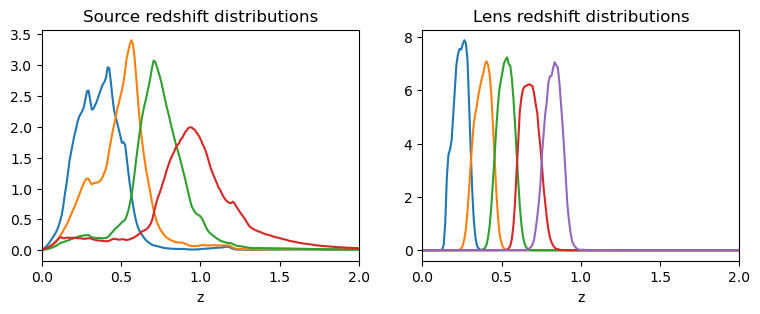

In [3]:
# Let's plot the NZs
figure(figsize=(9,3))
subplot(121)
plot(nz_source['Z_MID'], nz_source['BIN1'])
plot(nz_source['Z_MID'], nz_source['BIN2'])
plot(nz_source['Z_MID'], nz_source['BIN3'])
plot(nz_source['Z_MID'], nz_source['BIN4'])
xlim(0,2);
xlabel('z')
title('Source redshift distributions')
subplot(122)
plot(nz_lens['Z_MID'], nz_lens['BIN1'])
plot(nz_lens['Z_MID'], nz_lens['BIN2'])
plot(nz_lens['Z_MID'], nz_lens['BIN3'])
plot(nz_lens['Z_MID'], nz_lens['BIN4'])
plot(nz_lens['Z_MID'], nz_lens['BIN5'])
xlim(0,2);
title('Lens redshift distributions');
xlabel('z')

In [4]:
# Now let's try to build the equivalent with jax-cosmo

# This is the effective number of sources from the cosmic shear paper
neff_s = [1.47, 1.46, 1.50, 0.73]

nzs_s = [jc.redshift.kde_nz(nz_source['Z_MID'].astype('float32'),
                            nz_source['BIN%d'%i].astype('float32'), 
                            bw=0.01,
                            gals_per_arcmin2=neff_s[i-1])
           for i in range(1,5)]

nzs_l = [jc.redshift.kde_nz(nz_lens['Z_MID'].astype('float32'),
                              nz_lens['BIN%d'%i].astype('float32'), bw=0.01)
           for i in range(1,6)]

(0.0, 1.0)

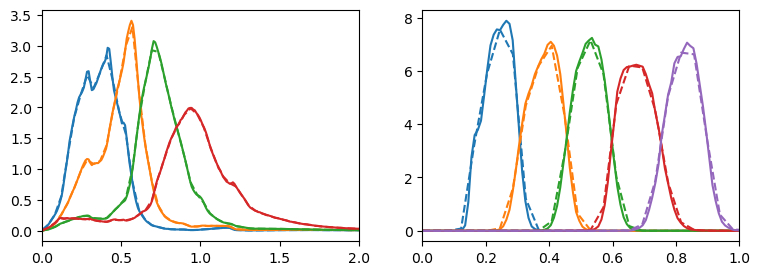

In [5]:
z = linspace(0,2)
figure(figsize=(9,3))
subplot(121)

for i in range(4):
    plot(nz_source['Z_MID'], nz_source['BIN%d'%(i+1)], color='C%d'%i)
    plot(z, nzs_s[i](z), '--', color='C%d'%i)

xlim(0,2)
subplot(122)

for i in range(5):
    plot(nz_lens['Z_MID'], nz_lens['BIN%d'%(i+1)], color='C%d'%i)
    plot(z, nzs_l[i](z), '--', color='C%d'%i)
xlim(0,1)

##  Let's build  a model for C_ell

In [6]:
# First, let's define a function to go to and from a 1d parameter vector
def get_params_vec(cosmo, m, dz, ia, bias):
    m1, m2, m3, m4 = m
    dz1, dz2, dz3, dz4 = dz
    A, eta = ia
    b1, b2, b3, b4, b5 = bias
    return np.array([ 
        # Cosmological parameters
        cosmo.sigma8, cosmo.Omega_c, cosmo.Omega_b,
        cosmo.h, cosmo.n_s, cosmo.w0,
        # Shear systematics
        m1, m2, m3, m4,
        # Photoz systematics
        dz1, dz2, dz3, dz4,
        # IA model
        A, eta,
        # linear galaxy bias
        b1, b2, b3, b4, b5
    ])
    
def unpack_params_vec(params):
    # Retrieve cosmology
    cosmo = jc.Cosmology(sigma8=params[0], Omega_c=params[1], Omega_b=params[2],
                         h=params[3], n_s=params[4], w0=params[5],
                         Omega_k=0., wa=0.)
    m1,m2,m3,m4 = params[6:10]
    dz1,dz2,dz3,dz4 = params[10:14]
    A = params[14]
    eta = params[15]
    bias = params[16:21]
    return cosmo, [m1,m2,m3,m4], [dz1,dz2,dz3,dz4], [A, eta], bias

# Let's try a round trip just to make sure
p = get_params_vec(jc.Planck15(), [1.,2.,3.,4.], [5.,6.,7.,8.],
              [1., 2.], [1.2, 1.4, 1.6, 1.8, 2.0])
unpack_params_vec(p)

(Cosmological parameters: 
     h:        0.6774 
     Omega_b:  0.0486 
     Omega_c:  0.2589 
     Omega_k:  0.0 
     w0:       -1.0 
     wa:       0.0 
     n:        0.9667 
     sigma8:   0.8159,
 [Array(1., dtype=float32),
  Array(2., dtype=float32),
  Array(3., dtype=float32),
  Array(4., dtype=float32)],
 [Array(5., dtype=float32),
  Array(6., dtype=float32),
  Array(7., dtype=float32),
  Array(8., dtype=float32)],
 [Array(1., dtype=float32), Array(2., dtype=float32)],
 Array([1.2, 1.4, 1.6, 1.8, 2. ], dtype=float32))

In [7]:
# Define some ell range
ell = np.logspace(1, 3)

@jax.jit
def mu(params):
    # First unpack parameter vector
    cosmo, m, dz, (A, eta), bias = unpack_params_vec(params) 

    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]

    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    # Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in bias] 

    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l, b)]
    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)

    return cl

In [8]:
# Let's try it out
fid_cosmo = jc.Cosmology(sigma8=0.801,
                          Omega_c=0.2545,
                          Omega_b=0.0485,
                          h=0.682,
                          n_s=0.971,
                          w0=-1., Omega_k=0., wa=0.)

fid_params = get_params_vec(fid_cosmo, 
                            [0., 0., 0., 0.],
                            [0., 0., 0., 0.],
                            [0.5, 0.],
                            [1.2, 1.4, 1.6, 1.8, 2.0])

In [9]:
cl_3x2pt = mu(fid_params)

/Users/kunhao/miniconda3/envs/py38/lib/python3.8/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [10]:
## Building a Fisher matrix, we just need the covarianc
@jax.jit
def cov(params):
    
    cl_signal = mu(params)
    
    # First unpack parameter vector
    cosmo, m, dz, (A, eta), bias = unpack_params_vec(params) 
    
    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]
    
    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    # Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in bias]
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l, b)]
    
    cl_noise = jc.angular_cl.noise_cl(ell, probes)
    
    cov = jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky=0.25, 
                                               sparse=False)
    
    return cov

In [11]:
C = cov(fid_params)

In [12]:
jacobian = jax.jit(jax.jacfwd(lambda p: mu(p).flatten()))

In [13]:
j = jacobian(fid_params)

In [14]:
%timeit jacobian(fid_params).block_until_ready()

1.31 s ± 20.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
import scipy

def symmetrized_matrix(U):
    u"""Return a new matrix like `U`, but with upper-triangle elements copied to lower-triangle ones."""
    M = U.copy()
    inds = onp.triu_indices_from(M,k=1)
    M[(inds[1], inds[0])] = M[inds]
    return M



def symmetric_positive_definite_inverse(M):
    u"""Compute the inverse of a symmetric positive definite matrix `M`.

    A :class:`ValueError` will be thrown if the computation cannot be
    completed.

    """
    import scipy.linalg
    U,status = scipy.linalg.lapack.dpotrf(M)
    if status != 0:
        raise ValueError("Non-symmetric positive definite matrix")
    M,status = scipy.linalg.lapack.dpotri(U)
    if status != 0:
        raise ValueError("Error in Cholesky factorization")
    M = symmetrized_matrix(M)
    return M

In [16]:
j64 = onp.array(j).astype(onp.float64)
C64 = onp.array(C).astype(onp.float64)

In [17]:
# And we get the fisher matrix from the jacobian and covariance
CC = symmetric_positive_definite_inverse(C64)
F = onp.einsum('ia,ij,jb->ab', j64, CC, j64)
F = 0.5*(F + F.T)

In [18]:
cov_estimate = symmetric_positive_definite_inverse(F)
onp.savetxt('cov_estimate_from_fisher.txt', cov_estimate)


In [19]:
def is_symmetric(X):
    return onp.all(X == X.T)

is_symmetric(F)

True

In [20]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos, i, j, nstd=1., ax=None, resize=False, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  # Extracts the block we are interested in
  cov = cov[:,[i,j]][[i,j],:]
  vals, vecs = eigsorted(cov)
  theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * sqrt(vals)
  xy = [pos[i], pos[j]]
  ellip = Ellipse(xy=xy, width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  if resize:
    sz = max(width, height)
    s1 = 1.5*nstd*sigma_marg(i)
    s2 = 1.5*nstd*sigma_marg(j)
    ax.set_xlim(pos[i] - s1, pos[i] + s1)
    ax.set_ylim(pos[j] - s2, pos[j] + s2)
  plt.draw()
  return ellip

In [21]:
fid_params

Array([ 0.801 ,  0.2545,  0.0485,  0.682 ,  0.971 , -1.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.5   ,  0.    ,  1.2   ,  1.4   ,  1.6   ,  1.8   ,  2.    ],      dtype=float32)

In [22]:
names = [
    "sigma8",
    "Omega_c",
    "Omega_b",
    "h",
    "n_s",
    "w0",
    "m1",
    "m2",
    "m3",
    "m4",
    "dz1",
    "dz2",
    "dz3",
    "dz4",
    "A",
    "eta",
    "b1",
    "b2",
    "b3",
    "b4",
    "b5",
]

(1.5, 2.0)

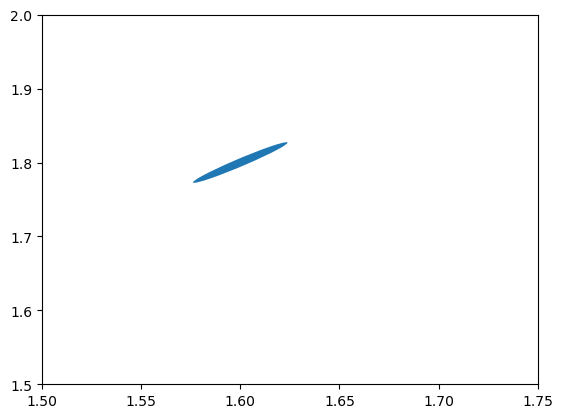

In [23]:
plot_contours(F, fid_params, 18, 19)
xlim(1.5, 1.75)
ylim(1.5, 2)

In [24]:
# parameter inverse mass matrix
M_inv = symmetric_positive_definite_inverse(F)
is_symmetric(M_inv)

True

In [25]:
#priors - index, mean, std. dev
prior_values = [
    (6, 0.012, 0.023),  #m1
    (7, 0.012, 0.023),  #m2
    (8, 0.012, 0.023),  #m3
    (9, 0.012, 0.023),  #m4
    (10, -0.001, 0.016),   #dz1
    (11, -0.019, 0.013),   #dz2
    (12,0.009, 0.011),   #dz3
    (13, -0.018, 0.022),   #dz4
]

In [26]:
def priors(p):
    logpi = 0.0
    dlogpi_dp = onp.zeros_like(p)
    for i, mu_i, sigma_i in prior_values:
        logpi += -0.5 * (p[i] - mu_i)**2 / sigma_i**2
        dlogpi_dp[i] = - (p[i] - mu_i) / sigma_i**2
    return logpi, dlogpi_dp

# returns -posterior P and -dL/dP
def fun(p, inv_cov=C, data=cl_3x2pt.flatten()):
    # theory C_ell prediction
    cl = mu(p).flatten()
    # d C_ell / d p
    j = jacobian(p).T
    d = cl - data
    dlogL_dCl = -inv_cov @ d
    logL = 0.5 * d @ dlogL_dCl
    dlogL_dp = j @ dlogL_dCl
    
    # Add Gaussian priors.
    # Can't use += because of JAX
    logPi, dlogPi_dp = priors(p)
    P = logL + logPi
    dP_dp = dlogL_dp + dlogPi_dp

    # convert back to regular numpy arrays
    return onp.array(P), onp.array(dP_dp)


In [27]:
%cd notebooks

[Errno 2] No such file or directory: 'notebooks'
/Users/kunhao/Library/CloudStorage/Dropbox/code/projects/jax_late_mod/jax_cosmo_late_mod/docs/notebooks


In [29]:
sys.path.append('/Users/kunhao/Dropbox/code/projects/jax_late_mod/jax_cosmo_late_mod/notebooks')
import hmc
importlib.reload(hmc)
onp.random.seed(100)
limits = [
    (0.5, 0.9), # sigma8
    (0.1, 0.5), # Omega_c
    (0.03, 0.06), # Omega_b
    (0.5,  0.9), # h
    (0.9,  1.05), # n_s
    (-2.0,  -0.5), # w0
    (-0.06, 0.06), #m1
    (-0.06, 0.06), #m2
    (-0.06, 0.06), #m3
    (-0.06, 0.06), #m4
    (-0.1, 0.1), #dz1
    (-0.1, 0.1), #dz2
    (-0.1, 0.1), #dz3
    (-0.1, 0.1), #dz4
    (0.0, 3.0),  #A
    (-3., 3.), #eta
    (0.8, 3.0), #bias1
    (0.8, 3.0), #bias2
    (0.8, 3.0), #bias3
    (0.8, 3.0), #bias4
    (0.8, 3.0), #bias5
]
data = onp.array(cl_3x2pt.flatten())
Cinv = onp.linalg.inv(C)
epsilon = 0.02 # time step
steps_per_iteration = 25
fun_kwargs = {'inv_cov': Cinv, 'data': data} 
sampler = hmc.HMC(fun, M_inv, epsilon, steps_per_iteration, limits, kwargs=fun_kwargs)
n_it = 1000
sampler.sample(n_it, fid_params)

Accept 0 alpha=0.82  p=0.11  ΔH=0.199
Accept 1 alpha=1.20  p=0.14  ΔH=-0.179
Accept 2 alpha=0.68  p=0.54  ΔH=0.382
Reject 3 alpha=0.64  p=0.70  Δh=0.452
Accept 4 alpha=2.91  p=0.59  ΔH=-1.068
Accept 5 alpha=0.23  p=0.16  ΔH=1.451
Reject 6 alpha=0.41  p=0.42  Δh=0.898
Accept 7 alpha=0.97  p=0.95  ΔH=0.027
Accept 8 alpha=1.09  p=0.88  ΔH=-0.084
Accept 9 alpha=1.30  p=0.05  ΔH=-0.264
Accept 10 alpha=1.17  p=0.48  ΔH=-0.161
Accept 11 alpha=1.39  p=0.50  ΔH=-0.326
Accept 12 alpha=1.07  p=0.55  ΔH=-0.063
Accept 13 alpha=2.93  p=0.00  ΔH=-1.074
Accept 14 alpha=1.33  p=0.68  ΔH=-0.283
Reject 15 alpha=0.73  p=0.96  Δh=0.321
Accept 16 alpha=0.90  p=0.88  ΔH=0.103
Accept 17 alpha=0.89  p=0.23  ΔH=0.113
Accept 18 alpha=0.67  p=0.67  ΔH=0.394
Accept 19 alpha=1.11  p=0.09  ΔH=-0.101
Accept 20 alpha=1.14  p=0.96  ΔH=-0.133
Reject 21 alpha=0.64  p=0.82  Δh=0.441
Accept 22 alpha=1.10  p=0.32  ΔH=-0.092
Accept 23 alpha=1.08  p=1.00  ΔH=-0.080
Accept 24 alpha=0.89  p=0.49  ΔH=0.120
Accept 25 alpha=0.90  

Accept 198 alpha=1.00  p=0.07  ΔH=0.003
Accept 199 alpha=0.92  p=0.13  ΔH=0.085
Accept 200 alpha=1.03  p=0.08  ΔH=-0.025
Accept 201 alpha=0.98  p=0.16  ΔH=0.021
Accept 202 alpha=0.87  p=0.52  ΔH=0.137
Accept 203 alpha=1.07  p=0.44  ΔH=-0.065
Accept 204 alpha=0.92  p=0.62  ΔH=0.083
Accept 205 alpha=1.01  p=0.89  ΔH=-0.015
Accept 206 alpha=1.19  p=0.49  ΔH=-0.177
Accept 207 alpha=1.10  p=0.92  ΔH=-0.097
Accept 208 alpha=1.20  p=0.52  ΔH=-0.186
Accept 209 alpha=0.96  p=0.52  ΔH=0.045
Accept 210 alpha=0.99  p=0.71  ΔH=0.007
Accept 211 alpha=0.82  p=0.28  ΔH=0.201
Accept 212 alpha=0.99  p=0.63  ΔH=0.007
Accept 213 alpha=1.08  p=0.02  ΔH=-0.076
Accept 214 alpha=0.95  p=0.74  ΔH=0.049
Note: parameter 6 reflecting at boundary 0.059999999999999984
Accept 215 alpha=1.15  p=0.45  ΔH=-0.137
Accept 216 alpha=0.87  p=0.53  ΔH=0.135
Accept 217 alpha=1.15  p=0.32  ΔH=-0.139
Accept 218 alpha=0.71  p=0.25  ΔH=0.346
Reject 219 alpha=0.77  p=0.85  Δh=0.264
Accept 220 alpha=1.04  p=0.51  ΔH=-0.040
Accept 2

KeyboardInterrupt: 

In [ ]:
figure(figsize=(10,10))
chain = onp.array(sampler.trace)
i=0
j=1
# plot_contours(F, fid_params, i, j, facecolor='w', edgecolor='b')
# for k in range(845):
#     path = onp.array(sampler.paths[k*steps_per_iteration:(k+1)*steps_per_iteration])
#     if sampler.trace_accept[k]:
# #         plot(path[:, i], path[:, j], '-', alpha=0.1)
#         plot(chain[k, i], chain[k, j], 'kx')
plot(chain[:, i], chain[:, j], 'kx')

In [ ]:
plot(sampler.trace_logP)
title("Get a load of this autocorrelation")

In [ ]:
limits


In [ ]:
nparam = len(names)
nplot = nparam
fig, axes = plt.subplots(nplot, nplot, figsize=(2*nplot,2*nplot), sharex=False, sharey=False)
pmin = chain.min(axis=0)
pmax = chain.max(axis=0)
for i, name1 in enumerate(names[:]):
    for j, name2 in enumerate(names[:]):
        if i>=nplot or j >= nplot:
            continue
        print(name1, name2)
        ax = axes[i, j]
        if i < j:
            fig.delaxes(ax)
            continue
        if i == j:
            ax.hist(chain[:, i], bins=20)
            ax.set_xlim(pmin[i], pmax[i])
        else:
            ax.hist2d(chain[:, j], chain[:, i], bins=20)
            plot_contours(F, fid_params, j, i, ax=ax, edgecolor='r', facecolor='none')
            ax.set_xlim(pmin[j], pmax[j])
            ax.set_ylim(pmin[i], pmax[i])
        if j == 0:
            ax.set_ylabel(name1)
        else:
            ax.get_yaxis().set_visible(False)

        if i == nplot-1:
            ax.set_xlabel(name2)
        else:
            ax.get_xaxis().set_visible(False)
subplots_adjust(wspace=0.05)
subplots_adjust(hspace=0.05)
# Expand for many plots

In [ ]:
savefig("corner.png")

In [ ]:
onp.savetxt("chain.txt", chain)

In [ ]:
!open .


In [ ]:
sampler2 = hmc.HMC(fun, M_inv, epsilon, steps_per_iteration, limits, kwargs=fun_kwargs)
%time sampler2.sample(1, fid_params)

In [ ]:
chain.shape